In [1]:
import os
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
from functools import reduce

In [2]:
class Seq:
    
    def __init__(self, name, description, sequence):
        self.name = name.lstrip('>')
        self.desc = description.split('(')[1].split(')')[0]
        self.seq = sequence.lower()


def read_seq(file):
    with open(file, 'r') as f:
        con = [i.rstrip('\n') for i in f.readlines()]
    return Seq(con[0], con[1], ''.join(con[2:]))


def load_sequences(folder):
    seq_files = [os.path.join(folder, i) for i in os.listdir(folder) if not i.startswith('.')]
    seqs = map(read_seq, seq_files)
    seqs_df_rows = [(x.name, x.desc, x.seq) for x in tqdm(seqs)]
    seqs_df = pd.DataFrame(seqs_df_rows, columns=['Name','CDSjoin','Sequence'])
    return seqs_df

## WAM模型
### 属性
- chunksize
    - 样本窗口宽度
- arr_length
    - 考虑碱基关联的阶数
- positive_weights
    - 阳性样本权重
- negative_weights
    - 阴性样本权重
### 方法
- fit
    - 拆分阳性和阴性样本
    - 统计碱基信息
    - 更新权重及归一化
- predict
    - predict_probas计算概率
    - predict_scores打分
    - predict_classes分类

In [3]:
class WAM:
    
    def __init__(self, chunk_size=21, arr_length=2, psuedo_count=0.5):
        self.chunk_size = chunk_size
        self.arr_length = arr_length
        
        # init wam weights
        weights_init = np.zeros( (chunk_size, 4**arr_length) , dtype=np.float)
        self.nucleo_arrays = self._nucleo_arrays(arr_length)
        self.positive_weights = pd.DataFrame(weights_init, columns=self.nucleo_arrays)
        self.negative_weights = pd.DataFrame(weights_init, columns=self.nucleo_arrays)
        
        # use psuedo count
        counts_init = np.full(weights_init.shape, psuedo_count)
        counts_init[0:2] = np.NaN
        self._init_count_matrix = pd.DataFrame(counts_init, columns=self.nucleo_arrays)
        
    def fit(self, data, labels):
        pos_indeces = labels == 1
        neg_indeces = labels == 0
        pos_data = data[pos_indeces].copy().reset_index(drop=True)
        neg_data = data[neg_indeces].copy().reset_index(drop=True)
        
        if pos_data.shape[0] > 0: 
            self.positive_weights += self._cal_freq_matrix(pos_data)
        if neg_data.shape[0] > 0:
            self.negative_weights += self._cal_freq_matrix(neg_data)
        
        self.positive_weights = self.positive_weights.apply(lambda x: x / x.sum(), axis=0)
        self.negative_weights = self.negative_weights.apply(lambda x: x / x.sum(), axis=0)
        
    def _cal_freq_matrix(self, data):
        # init
        count_matrix = self._init_count_matrix.copy()
        
        # count
        cn = self._count_nucleo
        count_matrix = count_matrix.apply(lambda x: x + (cn(data, x.name)), axis=0) # by column
        #print(count_matrix)
        # normalize
        count_matrix = count_matrix.apply(lambda x: x / x.sum(), axis=0) # by column
        
        return count_matrix
        
    def _count_nucleo(self, data, nucleo_pattern):
        
        # get all ends of pattern appeared in the sequence data
        #print(nucleo_pattern)
        nucleo_pat = re.compile(pattern=nucleo_pattern)
        find_ends = lambda x: [i.span()[1] for i in nucleo_pat.finditer(x)]
        ends = data.apply(find_ends)

        ends = reduce(lambda x, y: x + y, ends)
        #print(ends)
        # count ends as a feature vector
        l = len(data[0])
        
        #counts = [ends.count(i) for i in range(self.arr_length, l)]
        counts = [ends.count(i) for i in range(l)]
        #print(counts)
        return pd.Series(counts)
        
    def _nucleo_arrays(self, arr_length):
        bases = ['A', 'C', 'G', 'T']
        arrays = reduce(lambda x,y: [i+j for i in x for j in y], [bases] * arr_length)
        return arrays
        
    def predict_classes(self, data, T):
        scores = self.predict_scores(data)
        classes = np.zeros(scores.shape, dtype=np.int)
        isGreater = scores >= T
        classes[isGreater] = 1
        return classes
        
    def predict_probas(self, data):
        scores = data.apply(self._score).tolist()
        probas = pd.DataFrame(scores, columns=['Positive probability','Negative probability'])
        return probas
    
    def predict_scores(self, data):
        probas = self.predict_probas(data)
        score = np.log( probas.apply(lambda x: x[0] / x[1], axis=1) )
        return score
    
    def _score(self, sample):
        pos_weights = self.positive_weights
        neg_weights = self.negative_weights
        
        arrlen = self.arr_length
        pos_probas = [pos_weights.loc[i, sample[i-arrlen:i]] for i in range(arrlen, len(sample))]
        neg_probas = [neg_weights.loc[i, sample[i-arrlen:i]] for i in range(arrlen, len(sample))]
        
        pos_Proba = reduce(lambda x, y: x * y, pos_probas)
        neg_Proba = reduce(lambda x, y: x * y, neg_probas)
        
        # return positive and negative probas
        return [pos_Proba, neg_Proba]

In [4]:
model= WAM()

model.fit(pd.Series(['ACCGGCCGGAATGTTCCGGAT', 'ACCGGCCGGATTGTTCCGGTT','CCCGGCCGGAATGTTCCGGAT', 'GGCGGCCGGATTGTTCCGGTT']),
          pd.Series([1, 1, 0, 0]))
model.positive_weights[0:5]

,AA,AC,AG,AT,CA,CC,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.047619,0.217391,0.052632,0.043478,0.052632,0.032258,0.032258,0.052632,0.04,0.043478,0.032258,0.04,0.052632,0.043478,0.043478,0.04
3,0.047619,0.043478,0.052632,0.043478,0.052632,0.161290,0.032258,0.052632,0.04,0.043478,0.032258,0.04,0.052632,0.043478,0.043478,0.04
4,0.047619,0.043478,0.052632,0.043478,0.052632,0.032258,0.161290,0.052632,0.04,0.043478,0.032258,0.04,0.052632,0.043478,0.043478,0.04


In [5]:
model.negative_weights[0:5]

,AA,AC,AG,AT,CA,CC,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.047619,0.052632,0.052632,0.043478,0.052632,0.103448,0.032258,0.052632,0.04,0.04,0.090909,0.04,0.052632,0.043478,0.043478,0.04
3,0.047619,0.052632,0.052632,0.043478,0.052632,0.034483,0.032258,0.052632,0.04,0.12,0.030303,0.04,0.052632,0.043478,0.043478,0.04
4,0.047619,0.052632,0.052632,0.043478,0.052632,0.034483,0.161290,0.052632,0.04,0.04,0.030303,0.04,0.052632,0.043478,0.043478,0.04


In [6]:
model.predict_probas(pd.Series(['ACCGGCCGGAATGTTCCGGAT', 'ACCGGCCGGATTGTTCCGGTT']))

,Positive probability,Negative probability
0,2.951278e-15,1.331271e-16
1,2.479073e-15,1.118268e-16


In [65]:
# BN learning: https://github.com/pgmpy/pgmpy_notebook/blob/master/notebooks/9.%20Learning%20Bayesian%20Networks%20from%20Data.ipynb
from pgmpy.estimators import MmhcEstimator, MaximumLikelihoodEstimator, K2Score, BayesianEstimator, BDeuScore, BicScore
from pgmpy.models import BayesianModel

import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12.0, 8.0)


class BN:
    def __init__(self, struc_estr=MmhcEstimator, param_estr=BayesianEstimator):
        self.struc_estr = struc_estr
        self.param_estr = param_estr
        
        self.network = BayesianModel()
        
    def fit(self, data, label, sign_level=0.01):
        features = pd.DataFrame(data, columns=['F{}'.format(i) for i in range(data.shape[1])])
        label = pd.DataFrame(label, columns=['label'])
        data = pd.concat( (features, label), axis=1)
        
        # structure learning
        print('Performing structure learning, using estimator: `{}`'.format(self.struc_estr))
        self.struc_estr = self.struc_estr(data)
        
        DAG = self.struc_estr.estimate(significance_level=sign_level, scoring_method=BDeuScore(data))   
        # parameters, status for each feature ?
        
        self.network.add_edges_from(DAG.edges) 
        self.network.add_nodes_from( [ node for node in data.columns if not self.network.has_node(['node']) ] )
        # plot structure
        print('Done !')
        print('The structure now is: ')
        nx.draw(self.network, with_labels=True, node_color = 'b',edge_color = 'r', font_color='white', node_size=1000)
        # parameter learning
        print('Performing parameter learning, using estimator: `{}`'.format(self.param_estr))
        self.network.fit(data, estimator=self.param_estr)
        
    
    def predict_probas(self, data):
        data = self.make_missingL_data(data)
        probas = self.network.predict_probability(data)
        return probas
        
    def predict_classes(self, data):
        data = self.make_missingL_data(data)
        classes = self.network.predict(data)
        return classes
        
    def make_missingL_data(self, data):
        features = pd.DataFrame(data, columns=['F{}'.format(i) for i in range(data.shape[1])])
        label = pd.DataFrame(np.zeros(features.shape[0]), columns=['label'])
        data = pd.concat( (features, label), axis=1)
        data.drop('label', axis=1, inplace=True)
        return data

In [69]:
data = np.random.randint(0, 2, size=(5000, 20))
label = data.sum(axis=1)
test_data = np.random.randint(0, 2, size=(5000, 20))

Performing structure learning, using estimator: `<class 'pgmpy.estimators.MmhcEstimator.MmhcEstimator'>`


/home/chonghui/.local/lib/python3.8/site-packages/pgmpy/estimators/CITests.py:92: UserWarning: Insufficient data for testing label _|_ F3 | ['F1', 'F7', 'F18', 'F13', 'F0', 'F6']. At least 5120 samples recommended, 5000 present.
  warn(
/home/chonghui/.local/lib/python3.8/site-packages/pgmpy/estimators/CITests.py:92: UserWarning: Insufficient data for testing label _|_ F5 | ['F1', 'F7', 'F18', 'F13', 'F0', 'F6']. At least 5120 samples recommended, 5000 present.
  warn(
/home/chonghui/.local/lib/python3.8/site-packages/pgmpy/estimators/CITests.py:92: UserWarning: Insufficient data for testing label _|_ F8 | ['F1', 'F7', 'F18', 'F13', 'F0', 'F6']. At least 5120 samples recommended, 5000 present.
  warn(
/home/chonghui/.local/lib/python3.8/site-packages/pgmpy/estimators/CITests.py:92: UserWarning: Insufficient data for testing label _|_ F15 | ['F1', 'F7', 'F18', 'F13', 'F0', 'F6']. At least 5120 samples recommended, 5000 present.
  warn(
/home/chonghui/.local/lib/python3.8/site-packages/p

Done !
The structure now is: 
Performing parameter learning, using estimator: `<class 'pgmpy.estimators.BayesianEstimator.BayesianEstimator'>`


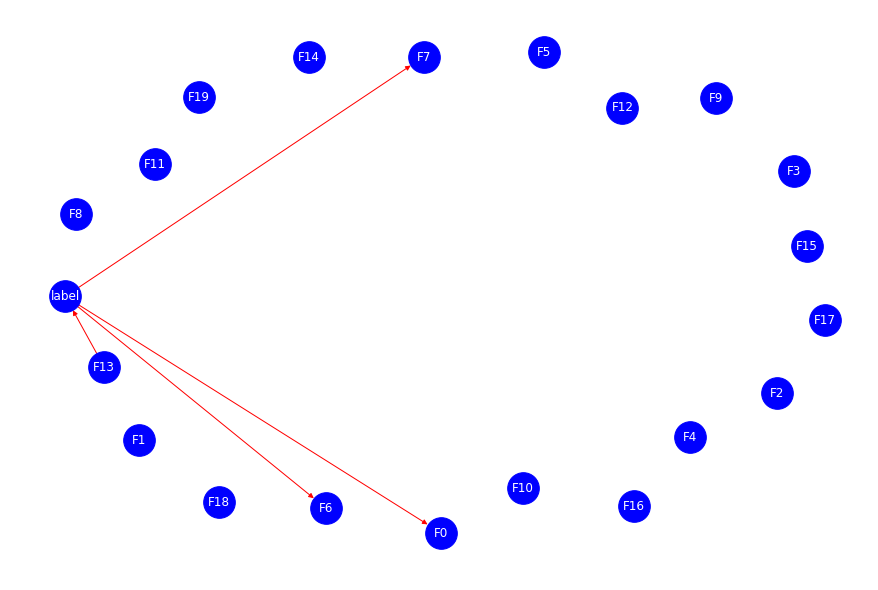

In [70]:
model = BN()
model.fit(data, label=label, sign_level=0.01)

    [1] Koller & Friedman, Probabilistic Graphical Models - Principles and Techniques, 2009
    Section 18.2.2.3 (page 789)
    [2] Neapolitan, Learning Bayesian Networks, Section 10.3 (page 600ff)
        http://www.cs.technion.ac.il/~dang/books/Learning%20Bayesian%20Networks(Neapolitan,%20Richard).pdf
    [3] Chi-square test https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test#Test_of_independence
    [4] Tsamardinos et al., The max-min hill-climbing BN structure learning algorithm, 2005, Section 4

Tsamardinos et al., The max-min hill-climbing Bayesian network structure learning algorithm (2005),

Algorithm 3

http (//www.dsl-lab.org/supplements/mmhc_paper/paper_online.pdf)

In [21]:
labels = nx.get_edge_attributes(model.network,'cpds')
labels


{}

In [34]:
print([i for i in model.network.edges])

[('F0', 'F15'), ('F7', 'F14'), ('F13', 'F17')]


In [35]:
model.predict_probas(test_data)

,label_0,label_1
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
5,0.5,0.5
6,0.5,0.5
7,0.5,0.5
8,0.5,0.5
9,0.5,0.5


In [26]:
class SVM:
    def __init__(self, ):
        pass
        

In [29]:
class Model:
    
    def __init__(self):
        self.WAM = WAM()
        self.BN = BN()
        self.SVM = SVM()